In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

import numba
import open3d as o3d

from hough3d import genIcosahedron, courseGrainField, pathIntegralAlongField3D
from hough3d import reducedRepConversionMatrices, distancePointToLine, unravel_3d_index

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Load Data

In [25]:
testData = np.random.uniform(-1, 1, size=(10000, 3))

#dataPath = '/home/jack/Workspaces/data/point_clouds/local_regions/local_region_points_0.npy'
dataPath = '/home/jack/Workspaces/python/skeletor/skeletor/data/simple_tree.npy'

with open(dataPath, 'rb') as f:
    data = np.load(f)

data = data - np.mean(data, axis=0)
data = np.ascontiguousarray(data).astype(np.float64)[::1]
data.shape

(1444, 3)

In [22]:
dataPath = '/home/jack/Workspaces/data/point_clouds/test_line_data/synthetic_c.dat'

data = np.genfromtxt(dataPath, skip_header=6, delimiter=',')

data = data - np.mean(data, axis=0)
data = np.ascontiguousarray(data).astype(np.float64)
data.shape

(398, 3)

## Basic Hough

In [36]:
from hough3d import hough3D

directionGranularity = 4
directionVectors = genIcosahedron(directionGranularity)

linePoints = hough3D(data, directionVectors, latticeSize=128, neighborDistance=0.01, minPointsPerLine=5)
linePoints.shape

(43, 2, 3)

In [37]:
flattenedLinePoints = linePoints.reshape((len(linePoints)*2, 3))

lineSet = o3d.geometry.LineSet()
lineSet.points = o3d.utility.Vector3dVector(flattenedLinePoints)
lineSet.lines = o3d.utility.Vector2iVector([[i,i+1] for i in range(len(flattenedLinePoints))[::2]])

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(data)

o3d.visualization.draw_geometries([lineSet, pcd])

## Integrated Hough

In [90]:
@numba.njit()
def rotationMatrix(theta, phi, psi):
    """
    Generate the rotation matrix corresponding to rotating
    a point in 3D space.
    """
    return np.array([[np.cos(theta)*np.cos(psi), np.cos(phi)*np.sin(psi) + np.sin(phi)*np.sin(theta)*np.cos(psi), np.sin(phi)*np.sin(psi) - np.cos(psi)*np.cos(phi)*np.sin(theta)],
                     [-np.cos(theta)*np.sin(psi), np.cos(phi)*np.cos(psi) + np.sin(phi)*np.sin(theta)*np.sin(psi), np.sin(phi)*np.cos(psi) - np.cos(psi)*np.sin(phi)*np.sin(theta)],
                     [np.sin(theta), -np.sin(phi)*np.cos(theta), np.cos(phi)*np.cos(theta)]])


@numba.njit()
def lineIntersection(a1, b1, a2, b2):
    """
    Compute the intersection of two lines:
        a1 + b1*t and a2 + b2*t
    """
    # Compute the cross product
    crossProd = np.cross(b1, b2)
    if crossProd == 0:
        return np.nan
    # Dot the cross product unit vector into the vector from intercept to intercept
    distance = np.dot(a2 - a1, crossProd) / np.sqrt(np.sum(crossProd**2))
    return distance

@numba.njit()
def distancePointToLine(p, a, b):
    """
    Compute intersection of a point (p) with a line (a + bt).

    Parameters
    ----------
    p : numpy.ndarray[3]
        Point to compute distance to the line

    a : numpy.ndarray[3]
        Point located on the line.

    b : numpy.ndarray[3]
        Direction vector of the line.

    Returns
    -------
    d : float
        Distance from the point to the closest point
        on the line.
    """
    t = np.dot(b, p - a)
    closestPointOnLine = a + t*b
    return np.sqrt(np.sum((p - closestPointOnLine)**2))


#@numba.njit()
def integratedHough3D(points, directionVectors, densityField, densityFieldCorner=np.array([0., 0., 0.]), densityFieldSpacing=np.array([1.,1.,1.]), latticeSize=64, neighborDistance=0.01, minPointsPerLine=5):
    """
    Perform line detection on a 3D point cloud.

    This version of the function is follows the algorithm described in
    the original paper [1] (except for step 5):
        1. Have all points vote in the hough space.
        2. Take the highest voted cell as an initial guess for a new line.
        3. Find all points less than a certain distance to the initial line.
        4. Perform linear regression on the nearby points to refine the line.
        5. Update which points are nearby to the line based on the updated line (NEW).
        6. Have all of the points that are part of this line reverse their vote.
        7. Repeat steps 2-6 until there are not enough points left to form a line.

    I found that adding step 5 gave slightly more reliable detections, so
    I have included it. Note that you could take this further, and perform
    several steps of fitting and updating, but here we just do one.
    
    Parameters
    ----------
    points : numpy.ndarray[N,3]
        Points representing the point cloud.

    directionVectors : numpy.ndarray[M,3]
        Direction vectors represented the discretized directions for
        the lines. Normally generated with `genIcosahedron()`.

    densityField : numpy.ndarray[Q,P,R]
        Course grained density field for the point cloud

    densityFieldCorner : numpy.ndarray[3]
        The point representing the bottom left (minimum) corner of the
        density field, if not [0,0,0].
        
    latticeSize : int
        The number of discrete boxes to use for the intercept variables in
        hough space.

    neighborDistance : float
        The distance a point can be from the initial guess of a
        line for it to be included in the linear regression
        used to refine the line parameters. Given as fraction of
        the total system size (diagonal length of the bounding box).

    minPointsPerLine : int
        The minimum number of points that must be part of a line
        detection for that line to be included in the final result.

    Returns
    -------
    lineDirections : numpy.ndarray[K,3]
        The vectors giving the directions of detected lines.

    lineAnchorPoints : numpy.ndarray[K,3]
        The position vectors of the anchor point for each line,
        roughly representing the center of the line (but not
        exactly).

    lineLengths : numpy.ndarray[K]
        The length of each line.
    """
    ##############################################
    #              Preparation steps
    ##############################################
    # Shift the mean of the point cloud to the origin
    pointCloudTranslation = np.zeros(3)
    for i in range(3):
        pointCloudTranslation[i] = np.mean(points[:,i])
        
    points = np.copy(points) - pointCloudTranslation
    
    # Compute the discrete direction vectors for our lines
    #directionVectors = genIcosahedron(directionGranularity)
    # TODO: Make this generation function numba compatable
    
    # Find the extents of the point cloud
    bounds = np.zeros((2, 3))
    for i in range(3):
        bounds[:,i] = [np.min(points[:,i]), np.max(points[:,i])]
    #bounds = np.array([ for i in range(3)]).T

    systemLengthScale = np.sqrt(np.sum((bounds[1] - bounds[0])**2))

    stepSize = systemLengthScale / latticeSize

    # Our hough space will be a three dimensional array, with the first two
    # dimensions representing the reduced coordinates x' and y' for the
    # intersection point of a line with a plane that passes through [0,0,0],
    # and the last dimension for the direction vector of the line. Altogether,
    # a point i,j,k in the hough space fully describes a line in the space
    # of the point cloud.
    houghSpaceSize = (latticeSize, latticeSize, len(directionVectors))

    ##############################################
    #    Initial transformation to hough space
    ##############################################
    # The actual hough space where points will be voting
    houghSpace = np.zeros(houghSpaceSize)

    # Now do the voting
    for k in range(len(directionVectors)):
        b = directionVectors[k]
        # We can compute a vector in advance that we just dot with
        # each point to find the x' and y'
        # See equation 2 in Dalitz et al. 2017
        reducedRepMultX, reducedRepMultY = reducedRepConversionMatrices(b)

        # I'm not 100% clear on why adding the system length scale is
        # necessary here, but otherwise most of our lattice represents
        # values of x' and y' that aren't relevant...
        xPrime = np.dot(reducedRepMultX, points.T) + systemLengthScale/2
        yPrime = np.dot(reducedRepMultY, points.T) + systemLengthScale/2
        #xPrime = np.dot(reducedRepMultX, points.T) + systemLengthScale/2
        #yPrime = np.dot(reducedRepMultY, points.T) + systemLengthScale/2

        # Now convert to an index, so we can find the corresponding
        # place on the hough space lattice.
        xIndex = np.floor(xPrime / stepSize).astype(np.uint8)
        yIndex = np.floor(yPrime / stepSize).astype(np.uint8)

        # Get rid of indices that are not on our lattice
        validIndices = np.where((xIndex < latticeSize) & (yIndex < latticeSize))[0]

        #print(validIndices)
        for j in validIndices:
            houghSpace[xIndex[j], yIndex[j], k] += 1

    ##############################################
    #    Iterative selection of lines
    ##############################################
    # Now that we have calulated our hough space, we need to identify
    # maxima in it to find the best lines

    # We do this by starting with the most voted point in hough space
    # and then "unvote" all of the points that are associated with that
    # line, and then repeat the process iteratively
    
    # # Naively, we just start by taking the maximum cells
    # maxIndices = np.where(houghSpace >= np.max(houghSpace)*selectionThreshold)
    # # Convert to a nicer format, so we can directly index using
    # # maxIndices[i]
    # maxIndices = [(maxIndices[0][i], maxIndices[1][i], maxIndices[2][i]) for i in range(len(maxIndices[0]))]

    # Numba doesn't play well with empty arrays because
    # it can't infer the type of the data, so we just start
    # with an empty line (all zeros) and we will remove
    # it at the end (see return statement).
    lineDirections = np.zeros((1, 3))
    lineAnchorPoints = np.zeros((1, 3))
    lineLengths = np.zeros(1)

    while True:
        # The highest voted space
        maxIndex = np.argmax(houghSpace)
        print(maxIndex)
        # Now we have to unravel the index, since it is given as a 1D index
        # The function numpy.unravel_index() does this, but it is not supported
        # by numba
        maxIndex = unravel_3d_index(maxIndex, houghSpaceSize)

        # Find the information about the line that this index
        # represents in hough space
        xIndex, yIndex, bIndex = maxIndex
        
        # If we don't have enough points, we finish
        if houghSpace[xIndex,yIndex,bIndex] < minPointsPerLine:
            break

        # Zero out the hough space here; this may not totally
        # be necessary considering that we unvote the points
        # later on, but this is just to be safe
        houghSpace[xIndex,yIndex,bIndex] = 0

        #plt.imshow(houghSpace[:,:,bIndex])
        #plt.colorbar()
        #plt.show()
        # Converted from index to reduced coordinates
        xPrime = xIndex*stepSize - systemLengthScale/2
        yPrime = yIndex*stepSize - systemLengthScale/2

        # Calculate the anchor point on the line, which,
        # together with the direction vector, fully identifies
        # the line.
        b = directionVectors[bIndex]
        reducedRepMultX, reducedRepMultY = reducedRepConversionMatrices(b)
        # See equation 3 from Dalitz et al. 2017
        anchorPoint = xPrime*reducedRepMultX + yPrime*reducedRepMultY

        # Now, we need to refine the line using linear regression.
        # First, that means identifying which points are included in
        # this line.

        ##############################################
        #    Compute line cut of density field
        ##############################################
        # Unlike the basic algorithm, here we try to better distinguish
        # if there are multiple, distinct line segments along this line.
        # eg. consider two line segments that are aligned with each other
        # but on opposite sides of the point cloud; these shouldn't be
        # detected as a single line, since the segment in the middle
        # isn't actually a real line segment.

        # To do this, we compute the path along this line through the
        # course-grained density field.
        pathPoints = 50
        # Add slight bit of padding so the path extends outside the
        # bounded volume
        pathBounds = [-systemLengthScale/1.5, systemLengthScale/1.5]
        pathStepDistances = np.linspace(pathBounds[0], pathBounds[1], pathPoints)
        
        pathAlongLine = anchorPoint + np.outer(pathStepDistances, b)
        densityFieldAlongLine = pathIntegralAlongField3D(densityField, pathAlongLine, densityFieldSpacing, densityFieldCorner)
        #print(densityFieldAlongLine)

        # plt.plot(densityFieldAlongLine)
        # plt.show()

        # Now we chop the line into segments based on the density along
        # the line.
        # To do this, first we take all points above a certain threshold
        densityThreshold = 0.01
        densityFieldAlongLine[densityFieldAlongLine >= densityThreshold] = 1
        densityFieldAlongLine[densityFieldAlongLine < 1] = 0
        
        # Next, we fill in gaps under the allowed distance
        allowedSkipDistance = neighborDistance
        allowedSkipDistance *= systemLengthScale / (pathStepDistances[1] - pathStepDistances[0])
        #print(allowedSkipDistance)

        for i in range(len(densityFieldAlongLine)):
            leftAllowedPoints = [i-k for k in range(int(np.floor(allowedSkipDistance))) if i-k >= 0]
            rightAllowedPoints = [i+k for k in range(int(np.floor(allowedSkipDistance))) if i+k < len(densityFieldAlongLine)]

            # If there is a high density point on both sides of the current point,
            # then we can fill in this current point.
            leftBounded = True in [densityFieldAlongLine[lI] == 1 for lI in leftAllowedPoints]
            rightBounded = True in [densityFieldAlongLine[rI] == 1 for rI in rightAllowedPoints]
            if leftBounded and rightBounded:
                densityFieldAlongLine[i] = 1

        # Now we split the line into regions that
        # are above the density threshold, since there could
        # be multiple lines that otherwise would get detected
        # as a single one.
        lineSegmentRegions = []
        inRegion = False
        for i in range(len(densityFieldAlongLine)):
            if densityFieldAlongLine[i] == 1 and not inRegion:
                lineSegmentRegions.append([i, 0])
                inRegion = True

            if densityFieldAlongLine[i] == 0 and inRegion:
                lineSegmentRegions[-1][1] = i-1
                inRegion = False

        #print(lineSegmentRegions)

        # If we have no regions, we can't continue
        if len(lineSegmentRegions) == 0:
            break
            
        # Identify points that are within a certain distance of the entire
        # line
        distancesToPoints = np.array([distancePointToLine(p, anchorPoint, b) for p in points])
        nearbyPointIndices = np.where(distancesToPoints < systemLengthScale*neighborDistance)[0]
        nearbyPoints = points[nearbyPointIndices]

        # fig = plt.figure()
        # ax = fig.add_subplot(projection='3d')
        
        # for j in range(len(lineSegmentRegions)):
        #     # Find which points are relevant to this line segment
        #     # Middle of line segment based on the line cut
        #     middleSegmentIndex = (lineSegmentRegions[j][0] + lineSegmentRegions[j][1]) / 2
        #     lineSegmentCenter = pathAlongLine[0] + middleSegmentIndex*(pathStepDistances[1] - pathStepDistances[0])*b
        #     # Add a bit of padding to the radius
        #     lineSegmentHalfWidth = (lineSegmentRegions[j][1] - lineSegmentRegions[j][0])*(pathStepDistances[1] - pathStepDistances[0])*1.1
        #     # Looking in a circle is fine because we have already restricted our points to
        #     # be on a line

        #     sphericalDistanceToPoints = np.sqrt(np.sum((lineSegmentCenter - nearbyPoints)**2, axis=-1))
        #     lineSegmentPointIndices = np.where(sphericalDistanceToPoints < lineSegmentHalfWidth)[0]
        #     #lineSegmentPointIndices = np.arange(len(nearbyPoints))
        #     lineSegmentPoints = nearbyPoints[lineSegmentPointIndices]
        #     ax.scatter(*lineSegmentPoints.T)
        #     print(j, len(lineSegmentPoints))
            
        # plt.show()
        
        # Now, we need to break these points up into the segments we identified through
        # the density analysis.
        print(lineSegmentRegions)
        for j in range(len(lineSegmentRegions)):
            
            plt.plot(densityFieldAlongLine)
            plt.axvline(lineSegmentRegions[j][0], c='r')
            plt.axvline(lineSegmentRegions[j][1], c='r')
            plt.title(j)
            plt.show()

            # Find which points are relevant to this line segment
            # Middle of line segment based on the line cut
            middleSegmentIndex = (lineSegmentRegions[j][0] + lineSegmentRegions[j][1]) / 2
            lineSegmentCenter = pathAlongLine[0] + middleSegmentIndex*(pathStepDistances[1] - pathStepDistances[0])*b
            # Add a bit of padding to the radius
            lineSegmentHalfWidth = (lineSegmentRegions[j][1] - lineSegmentRegions[j][0])*(pathStepDistances[1] - pathStepDistances[0])*1.1
            # Looking in a circle is fine because we have already restricted our points to
            # be on a line

            print(f'Line segment center: {lineSegmentCenter}')
            print(f'Line segment half width: {lineSegmentHalfWidth}')

            sphericalDistanceToPoints = np.sqrt(np.sum((lineSegmentCenter - nearbyPoints)**2, axis=-1))
            # plt.hist(sphericalDistanceToPoints, bins=30)
            # plt.show()
            
            lineSegmentPointIndices = np.where(sphericalDistanceToPoints < lineSegmentHalfWidth)[0]
            #lineSegmentPointIndices = np.arange(len(nearbyPoints))
            lineSegmentPoints = nearbyPoints[lineSegmentPointIndices]

            # Remove the used points from the list
            keepIndices = np.array([i for i in range(len(points)) if i not in lineSegmentPointIndices], dtype=np.int64)
            print(f'removed {len(points) - len(keepIndices)} points')
            points = points[keepIndices]

            ##############################################
            #    Refining line parameters
            ##############################################
            # If we have enough points, we continue on to calculate the
            # properties of the line
            # Otherwise, we just unvote these points and move on.
            if len(lineSegmentPoints) >= minPointsPerLine:
    
                # Now we perform linear regression on those points to fit a line
                # and increase the accuracy of our detected line
        
                # We will use SVD to find the first principle component
                # of the local points, which is equivalent to a linear
                # fit.
                # To do this, we need our data to be zero-centered
                # (and we need the center of mass point anyway as our
                # anchor point)
                anchorPoint = np.zeros(3)
                for i in range(3):
                    anchorPoint[i] = np.mean(lineSegmentPoints[:,i])
    
                # SVD on the mean-centered data.
                # The original paper did PCA instead of SVD, as they said it
                # was much faster, but I think SVD is fine here...
                uu, dd, vv = np.linalg.svd(lineSegmentPoints - anchorPoint)
                # Direction vector is the first principle component
                directionVector = vv[0]
                    
                # Compute the length of the line
                # The best way to do this is to compute the parametric representation
                # of every point in lineSegmentPoints. Then we can take the maximum and
                # minimum parametric values, to find how far the line extends in each direction
                tArr = np.dot(directionVector, (lineSegmentPoints - lineSegmentCenter).T)
                lineStart = lineSegmentCenter + np.max(tArr)*directionVector
                lineEnd = lineSegmentCenter + np.min(tArr)*directionVector
    
                # lineBounds = np.zeros((2, 3))
                # for i in range(3):
                #     lineBounds[:,i] = [np.min(lineSegmentPoints[:,i]), np.max(lineSegmentPoints[:,i])]
                    
                # Now we project these points onto our line
                #t = np.dot(directionVector, lineBounds[0] - lineSegmentCenter)
                #lineStart = lineSegmentCenter + t*directionVector
                #lineStart = pathAlongLine[lineSegmentRegions[j][0]]
                #t = np.dot(directionVector, lineBounds[1] - lineSegmentCenter)
                #lineEnd = lineSegmentCenter + t*directionVector
                #lineEnd = pathAlongLine[lineSegmentRegions[j][1]]
    
                lineCenter = (lineStart + lineEnd)/2
                length = np.sqrt(np.sum((lineEnd - lineStart)**2))
    
                # Save the information about this line
                lineDirections = np.concatenate((lineDirections, directionVector[None,:]))
                #lineAnchorPoints = np.concatenate((lineAnchorPoints, anchorPoint[None,:]))
                lineLengths = np.append(lineLengths, length)
                lineAnchorPoints = np.concatenate((lineAnchorPoints, lineCenter[None,:]))
                #lineLengths = np.append(lineLengths, lineSegmentHalfWidth*2)
                    
            ##############################################
            #    Removing votes from used points
            ##############################################
            # Now, we want to have all of the points
            # involved in this fit to "unvote" in the hough space,
            # such that we can find the next best line
            for k in range(len(directionVectors)):
                b = directionVectors[k]
                # We can compute a vector in advance that we just dot with
                # each point to find the x' and y'
                # See equation 2 in Dalitz et al. 2017
                reducedRepMultX, reducedRepMultY = reducedRepConversionMatrices(b)
        
                # I'm not 100% clear on why adding the system length scale is
                # necessary here, but otherwise most of our lattice represents
                # values of x' and y' that aren't relevant...
                xPrime = np.dot(reducedRepMultX, lineSegmentPoints.T) + systemLengthScale/2
                yPrime = np.dot(reducedRepMultY, lineSegmentPoints.T) + systemLengthScale/2
                #xPrime = np.dot(reducedRepMultX, points.T) + systemLengthScale/2
                #yPrime = np.dot(reducedRepMultY, points.T) + systemLengthScale/2
        
                # Now convert to an index, so we can find the corresponding
                # place on the hough space lattice.
                xIndex = np.floor(xPrime / stepSize).astype(np.uint8)
                yIndex = np.floor(yPrime / stepSize).astype(np.uint8)
        
                # Get rid of indices that are not on our lattice
                validIndices = np.where((xIndex < latticeSize) & (yIndex < latticeSize))[0]
                
                #print(validIndices)
                for j in validIndices:
                    houghSpace[xIndex[j], yIndex[j], k] -= 1

            ##############################################
            #    DEBUG
            ##############################################
            # Uncomment these to plot each line after it is detected.
            # Doesn't work with numba, so you'll have to remove the annotation.

            if len(lineSegmentPoints) > minPointsPerLine:
                linePoints = np.array([[lineAnchorPoints[i] - lineDirections[i]*lineLengths[i]/2, lineAnchorPoints[i] + lineDirections[i]*lineLengths[i]/2] for i in range(len(lineDirections))])
                
                linePoints = linePoints.reshape((len(linePoints)*2, 3))
                
                lineSet = o3d.geometry.LineSet()
                lineSet.points = o3d.utility.Vector3dVector(linePoints)
                lineSet.lines = o3d.utility.Vector2iVector([[i,i+1] for i in range(len(linePoints))[::2]])
                
                pcd = o3d.geometry.PointCloud()
                pcd.points = o3d.utility.Vector3dVector(lineSegmentPoints)
                
                o3d.visualization.draw_geometries([lineSet, pcd])
            ##############################################
            #    DEBUG
            ##############################################        

    # Remove the first entry, since that was a dummy entry
    return lineDirections[1:], lineAnchorPoints[1:], lineLengths[1:]

[-207.99157017  -33.91979941 -460.3697479 ]
56518461
[[15, 19]]


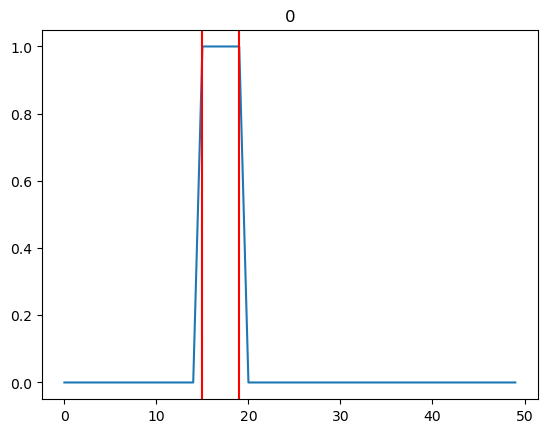

Line segment center: [ -18.31401002   21.60024018 -412.82652387]
Line segment half width: 160.22985531542156
removed 77 points
41150976
[[12, 12], [14, 30]]


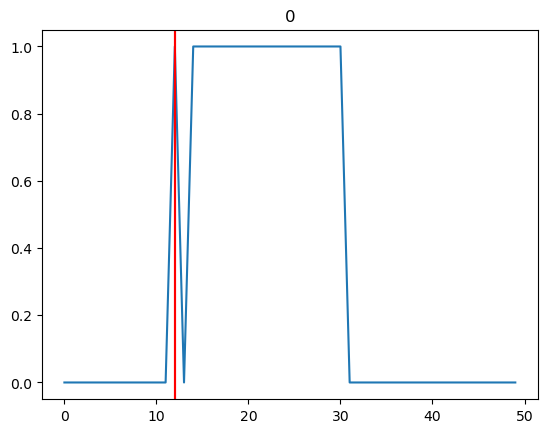

Line segment center: [-24.6154519  -26.30885596 454.52257166]
Line segment half width: 0.0
removed 0 points


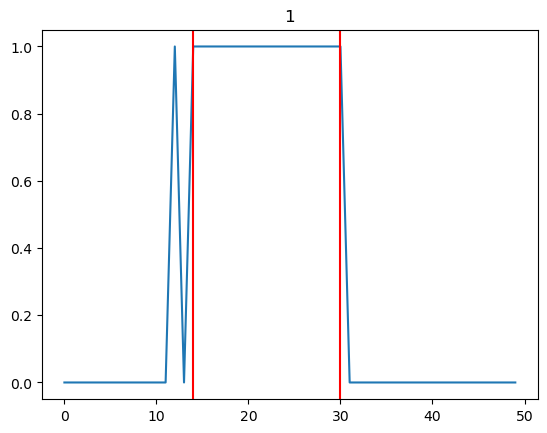

Line segment center: [728.29663002 -55.46022308 887.86317742]
Line segment half width: 640.9194212616862
removed 0 points
41149695
[[16, 16], [18, 30]]


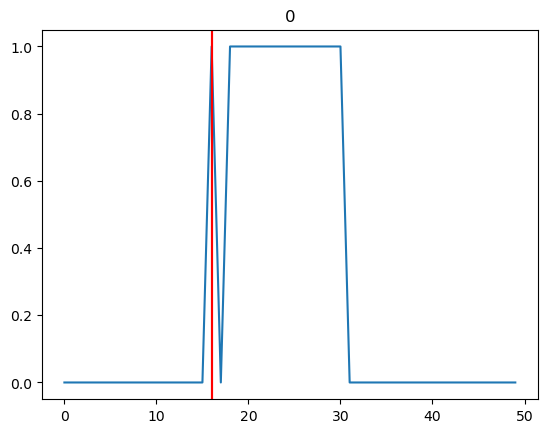

Line segment center: [ -3.92751023 -19.0341033  310.42443769]
Line segment half width: 0.0
removed 0 points


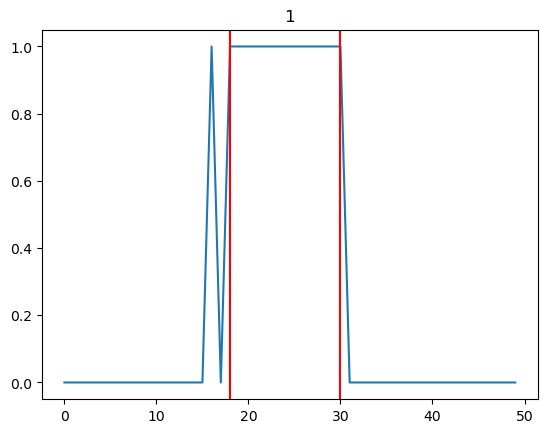

Line segment center: [805.73725921 -57.90259279 888.21191204]
Line segment half width: 480.6895659462646
removed 0 points
36878841
[[4, 5], [9, 9], [12, 12]]


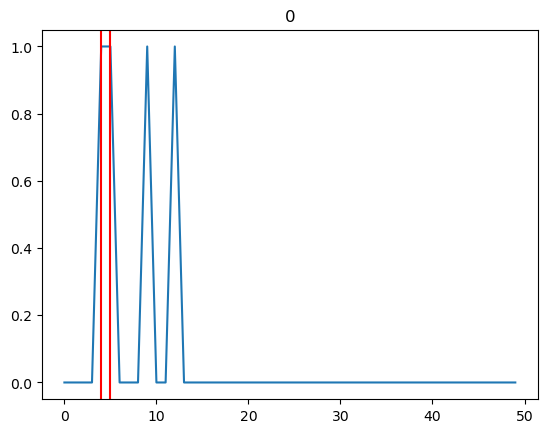

Line segment center: [  8.68162022  -1.70965034 735.30332427]
Line segment half width: 40.05746382885539
removed 7 points


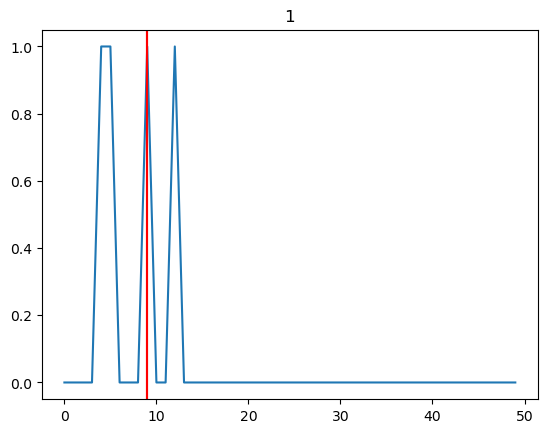

Line segment center: [318.33555809 -12.64141301 897.80605143]
Line segment half width: 0.0
removed 0 points


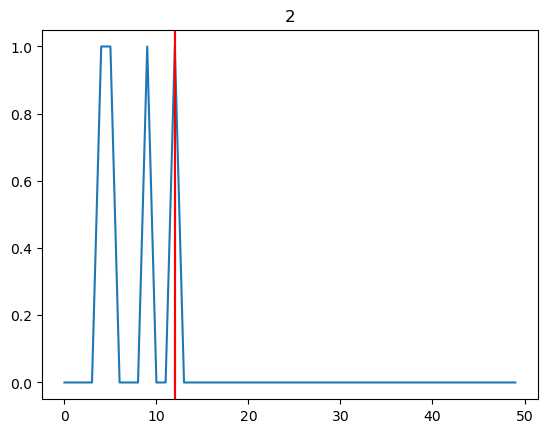

Line segment center: [427.58318672 -12.64141301 897.80605143]
Line segment half width: 0.0
removed 0 points
40821759
[[25, 25], [27, 30]]


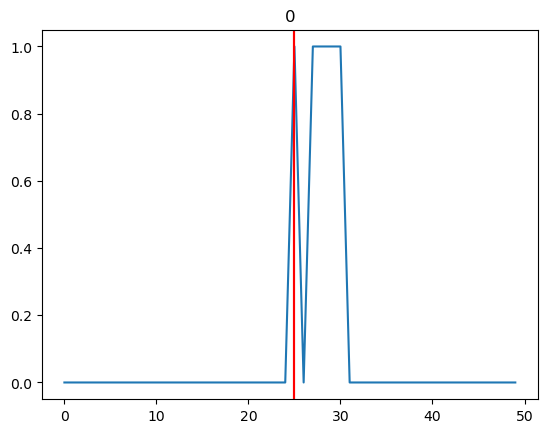

Line segment center: [ 34.64909202   7.43829882 -14.00396036]
Line segment half width: 0.0
removed 0 points


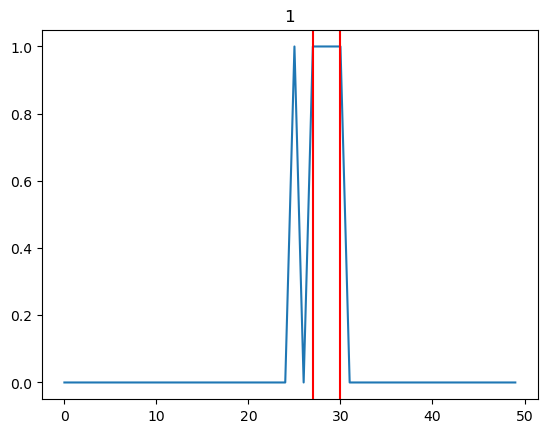

Line segment center: [972.00740841 -53.29371602 888.78896832]
Line segment half width: 120.17239148656616
removed 0 points
42789431
[[20, 29], [31, 31], [34, 35]]


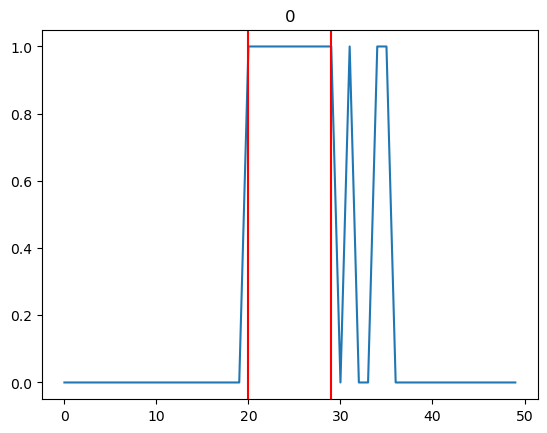

Line segment center: [-10.35537472 -26.13834865  -1.44233752]
Line segment half width: 360.5171744596985
removed 44 points


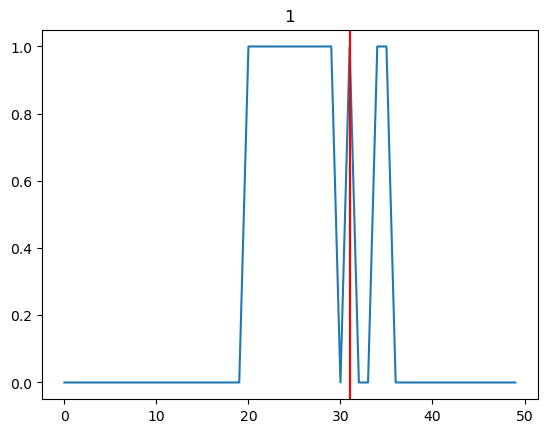

Line segment center: [995.45731931 -26.13834865 882.21630555]
Line segment half width: 0.0
removed 0 points


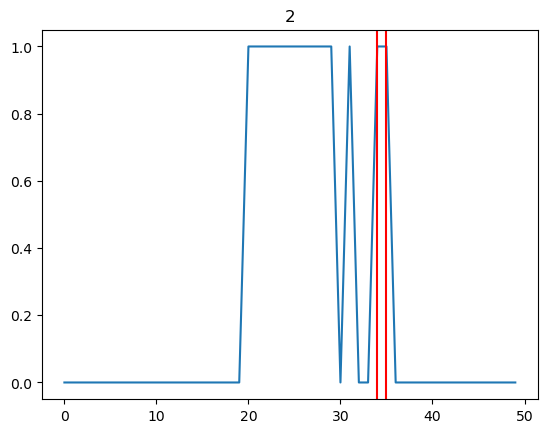

Line segment center: [1122.91288604  -26.13834865  882.21630555]
Line segment half width: 40.05746382885539
removed 0 points
37206777
[[2, 13]]


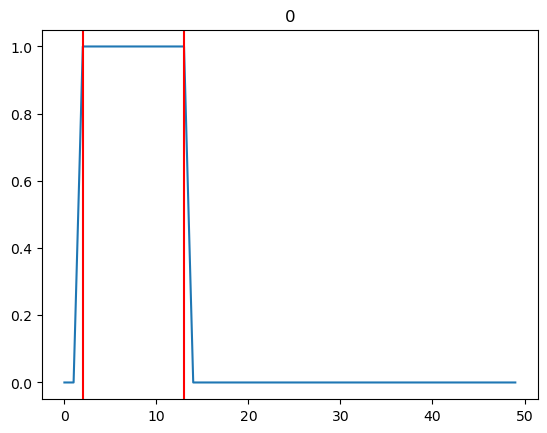

Line segment center: [ 18.34221262   0.96931467 626.39111654]
Line segment half width: 440.63210211740926
removed 36 points
39838007
[[10, 13]]


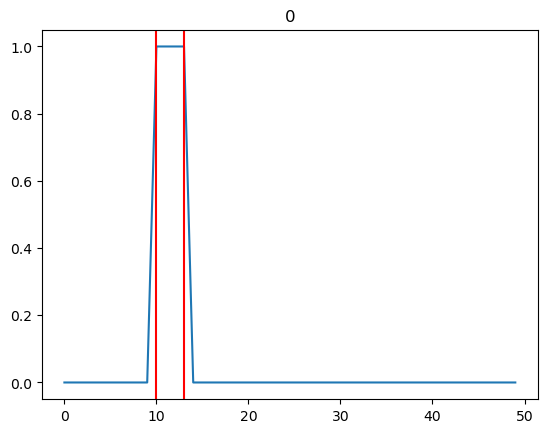

Line segment center: [-29.0636615  -26.13834865 473.92827764]
Line segment half width: 120.17239148656616
removed 13 points
40165979
[[13, 20]]


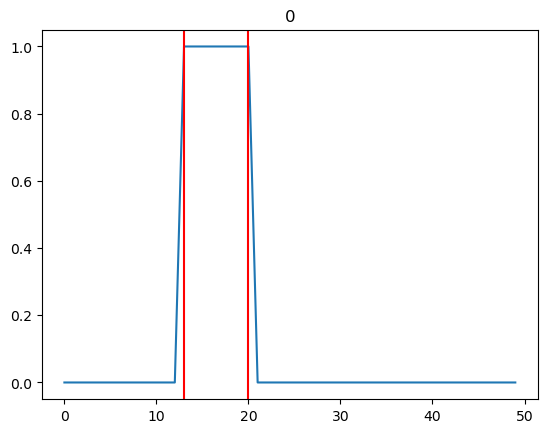

Line segment center: [-12.16503014 -19.01752873 293.3066869 ]
Line segment half width: 280.4022468019877
removed 13 points
40172348
[[23, 26]]


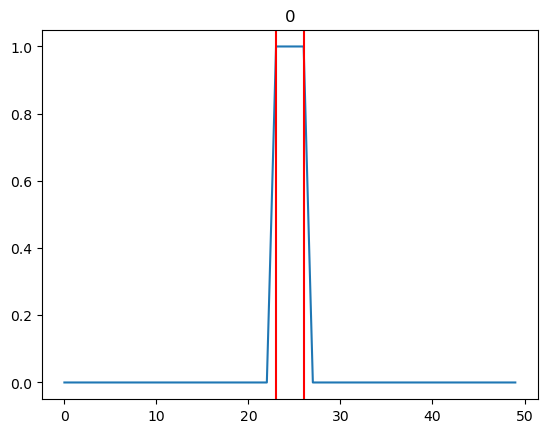

Line segment center: [31.06612417  0.          4.32701256]
Line segment half width: 120.17239148656616
removed 0 points
40495196
[[17, 25]]


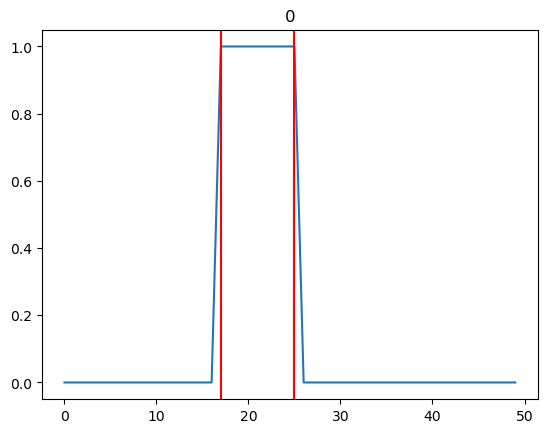

Line segment center: [ 10.01008198  -7.50478223 131.18257413]
Line segment half width: 320.4597106308431
removed 0 points
42133491
[[18, 23]]


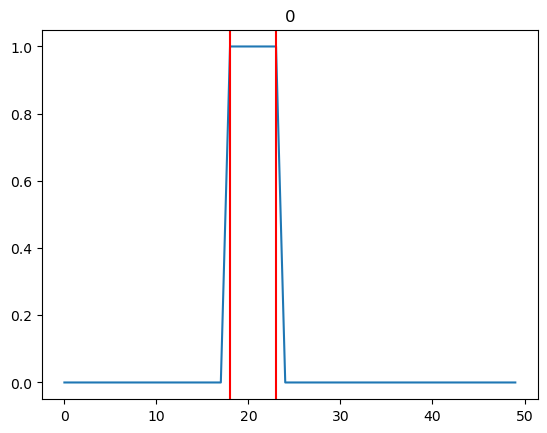

Line segment center: [ 11.2552078   -7.92703987 147.34840429]
Line segment half width: 200.28731914427695
removed 0 points
42788082
[[23, 24]]


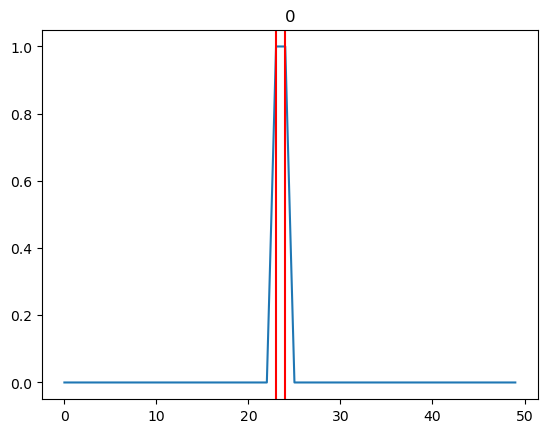

Line segment center: [29.59833681 -0.39199802 39.28157415]
Line segment half width: 40.05746382885539
removed 0 points
41148478
[[18, 23]]


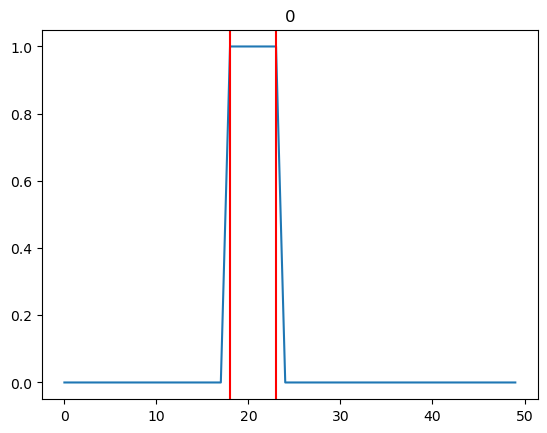

Line segment center: [ 10.53748099  -8.31043857 149.22311695]
Line segment half width: 200.28731914427695
removed 0 points
41476414
[[20, 24]]


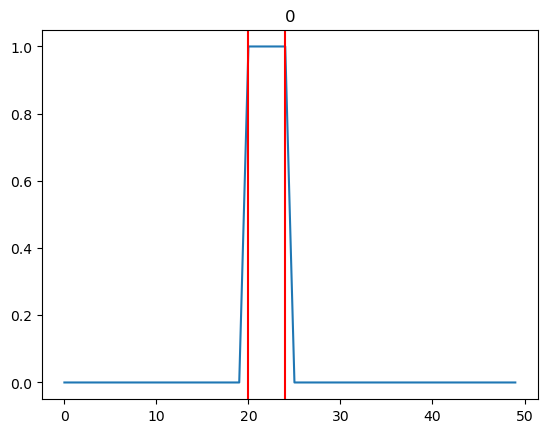

Line segment center: [18.2075476  -6.16284805 94.93087483]
Line segment half width: 160.22985531542156
removed 0 points
40173629
[[24, 26]]


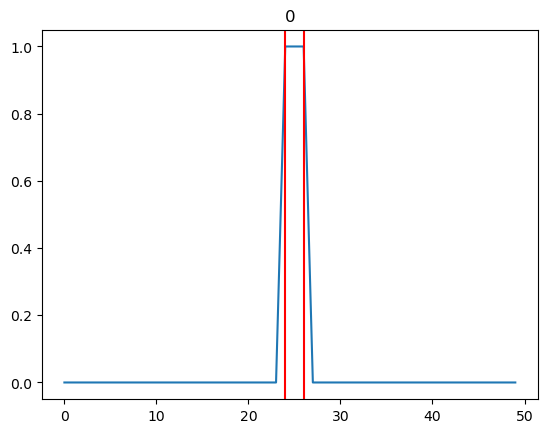

Line segment center: [ 33.57795006   5.22766973 -13.7068373 ]
Line segment half width: 80.11492765771078
removed 0 points
40825694
[[24, 24], [26, 29]]


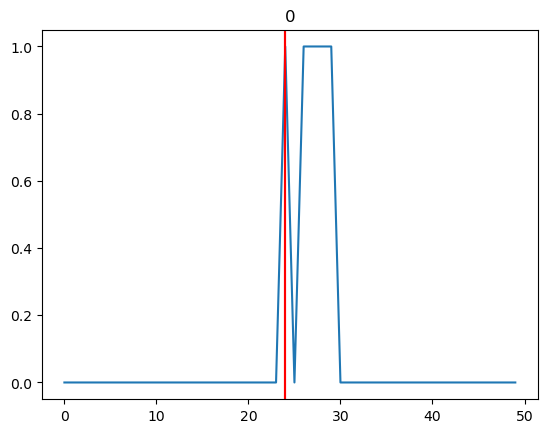

Line segment center: [18.99790859  4.34503754 22.32262852]
Line segment half width: 0.0
removed 0 points


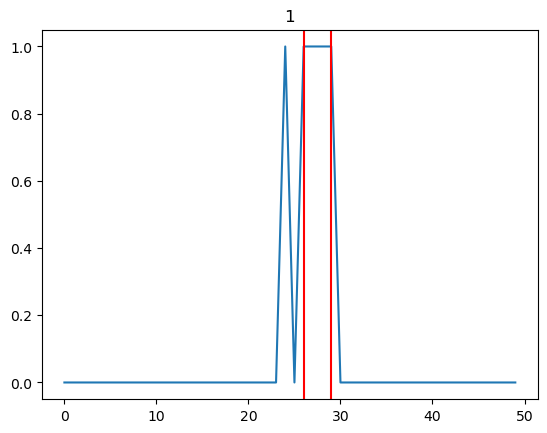

Line segment center: [863.47107634 -53.86594045 880.12027561]
Line segment half width: 120.17239148656616
removed 0 points
41148414
[[23, 25], [28, 29]]


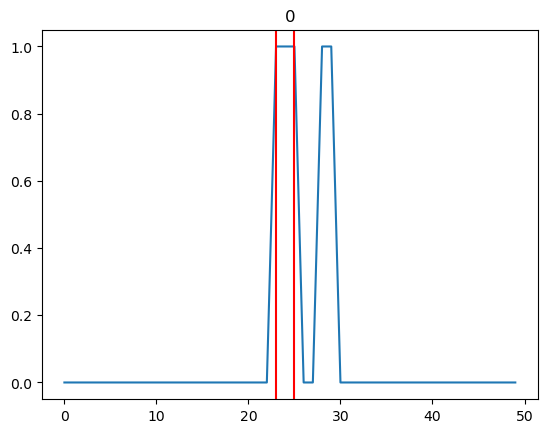

Line segment center: [32.83949631 -2.04222827 21.87943512]
Line segment half width: 80.11492765771078
removed 0 points


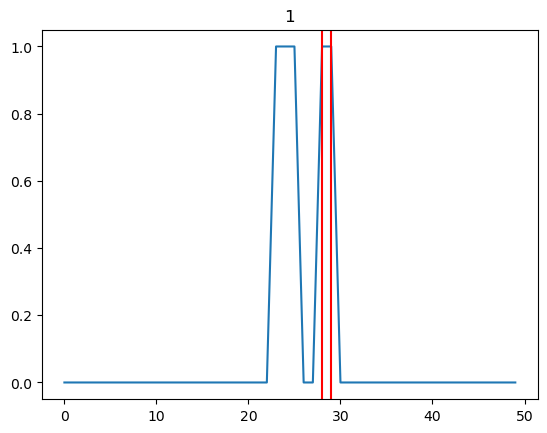

Line segment center: [974.21757893 -60.34496251 888.56064666]
Line segment half width: 40.05746382885539
removed 0 points
42460146
[[22, 23]]


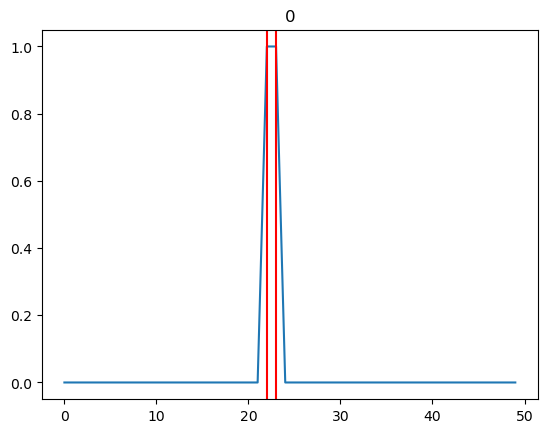

Line segment center: [24.24773138 -0.59091216 75.67904694]
Line segment half width: 40.05746382885539
removed 0 points
42788012
[[25, 30]]


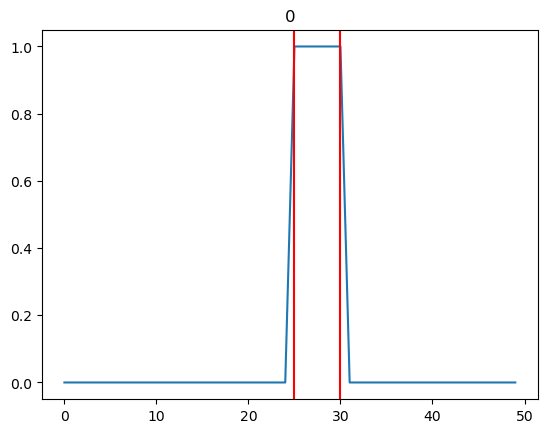

Line segment center: [  37.20234492   11.91154556 -107.24871191]
Line segment half width: 200.28731914427695
removed 0 points
43443954
[[28, 30]]


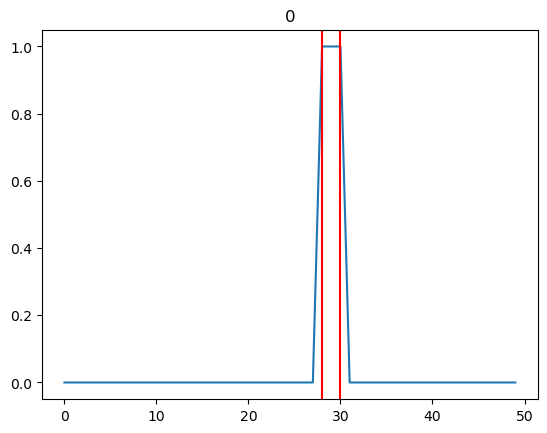

Line segment center: [  50.7818077    16.96648327 -159.39974863]
Line segment half width: 80.11492765771078
removed 0 points
44762037
[[28, 29]]


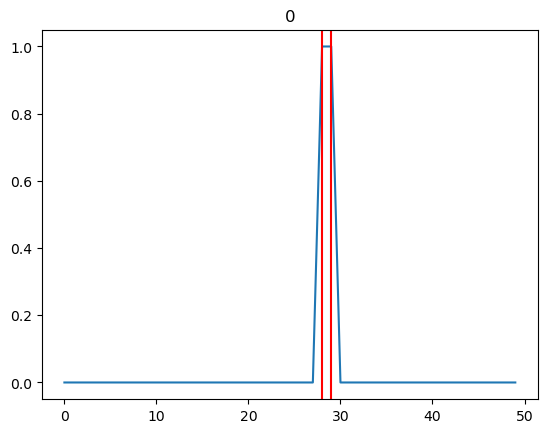

Line segment center: [  46.50818007   17.53760223 -143.26071631]
Line segment half width: 40.05746382885539
removed 0 points
38862009
[[20, 21]]


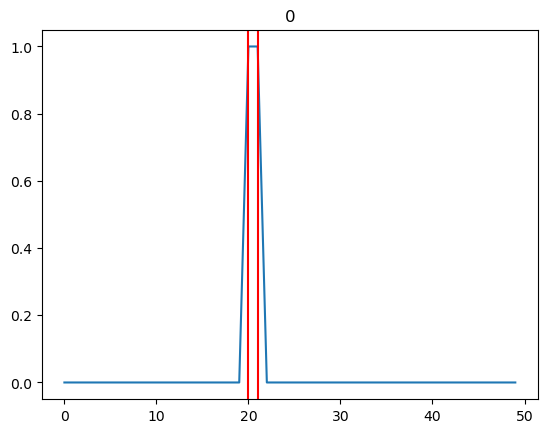

Line segment center: [ 10.1422991  -11.57218714 154.08197982]
Line segment half width: 40.05746382885539
removed 0 points
39510197
[[18, 21]]


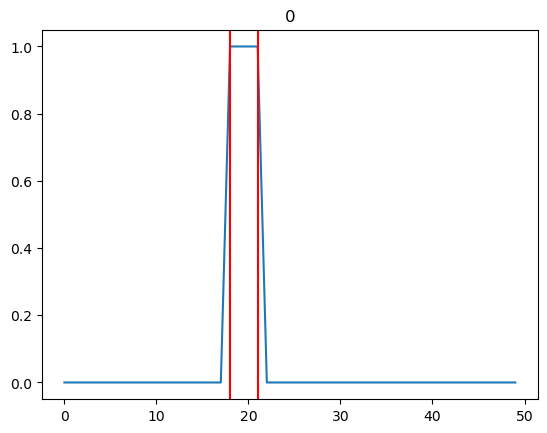

Line segment center: [  2.73873609 -14.14515357 188.08921871]
Line segment half width: 120.17239148656616
removed 0 points
39843221
[[21, 23]]


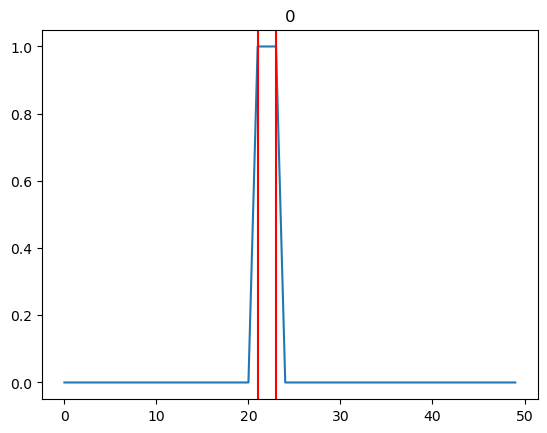

Line segment center: [17.04451703 -5.22766973 96.62715818]
Line segment half width: 80.11492765771078
removed 0 points
40168505
[[15, 20]]


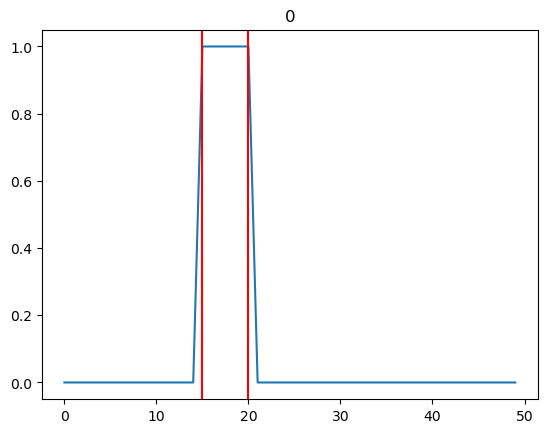

Line segment center: [ -4.09943823 -15.68300919 256.80091058]
Line segment half width: 200.28731914427695
removed 2 points
40171067
[[20, 24]]


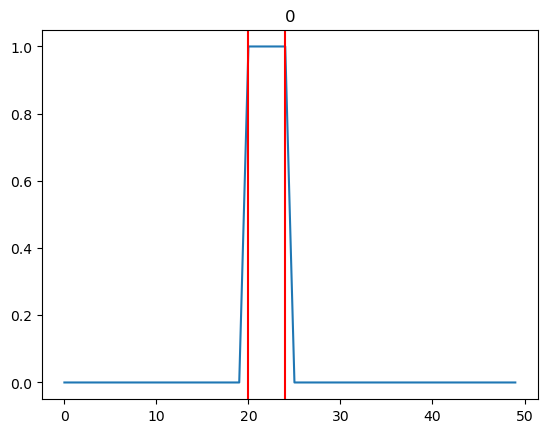

Line segment center: [18.50699474 -5.22766973 94.49626185]
Line segment half width: 160.22985531542156
removed 0 points
40172256
[[23, 26]]


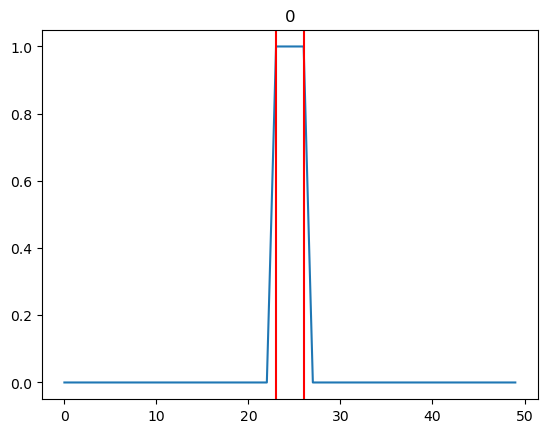

Line segment center: [31.290955    0.          2.16869628]
Line segment half width: 120.17239148656616
removed 0 points
40172438
[[23, 25]]


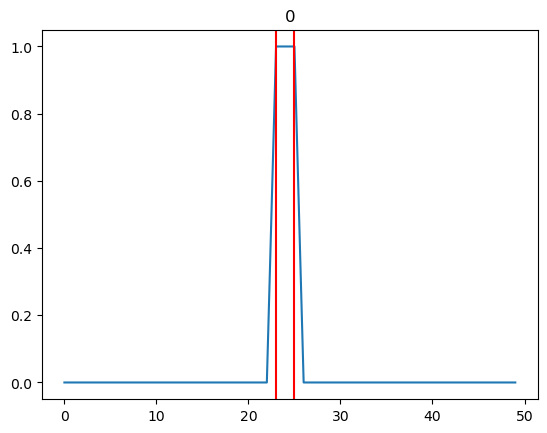

Line segment center: [26.93989825  0.         24.28163917]
Line segment half width: 80.11492765771078
removed 0 points
40496477
[[20, 20], [22, 26]]


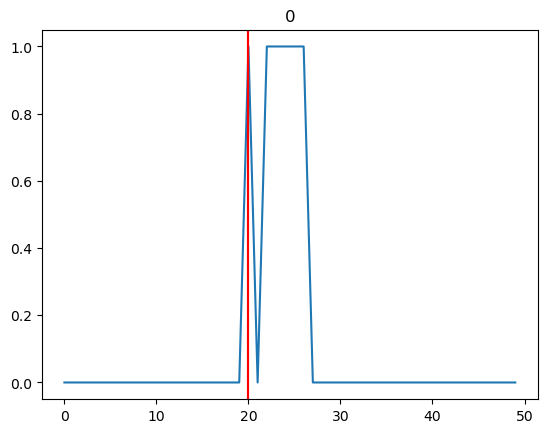

Line segment center: [ 9.28678878e-02 -5.95498026e+00  1.66575957e+02]
Line segment half width: 0.0
removed 0 points


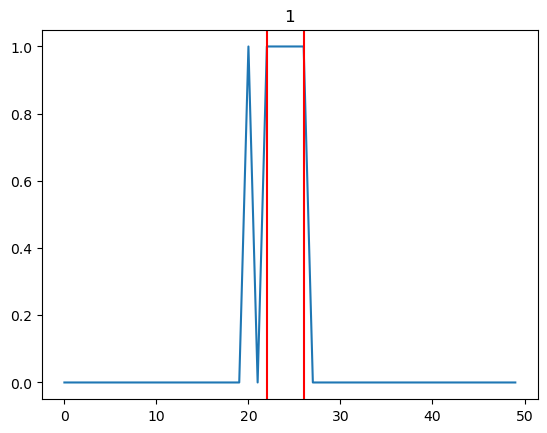

Line segment center: [743.27104024 -54.46412858 881.40732956]
Line segment half width: 160.22985531542156
removed 0 points
40504161
[[23, 24]]


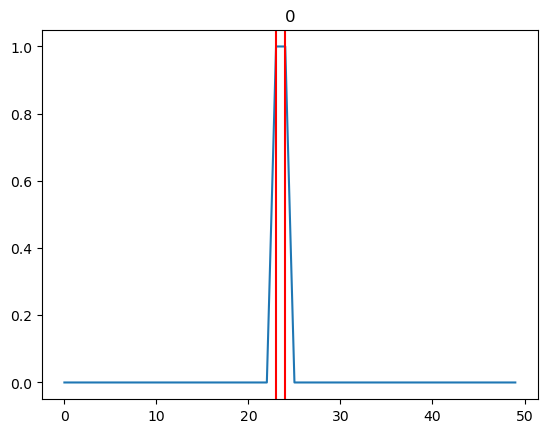

Line segment center: [22.9833678  -2.5341207  41.48046678]
Line segment half width: 40.05746382885539
removed 0 points
40824285
[[18, 20]]


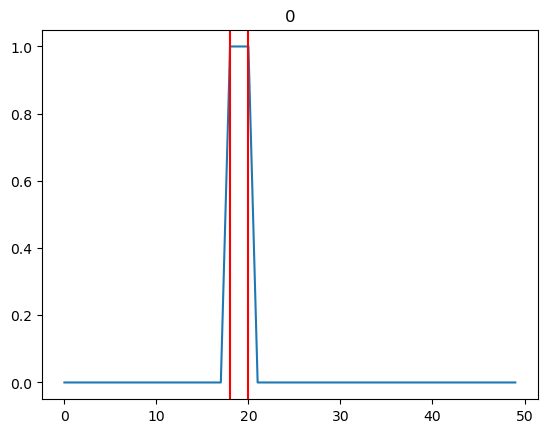

Line segment center: [  7.01245361 -15.68300919 201.25380045]
Line segment half width: 80.11492765771078
removed 0 points
40830872
[[27, 29]]


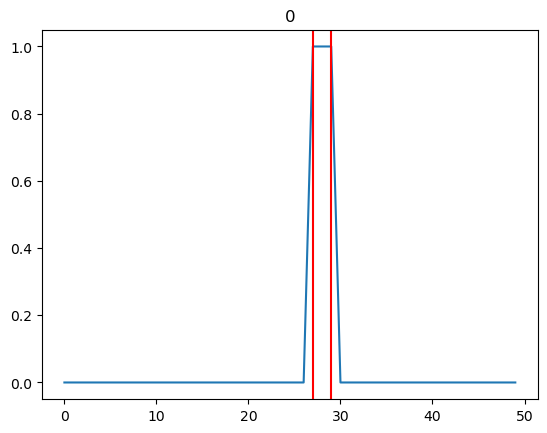

Line segment center: [  46.73066071   10.45533946 -120.40939886]
Line segment half width: 80.11492765771078
removed 0 points
41490439
[[24, 25]]


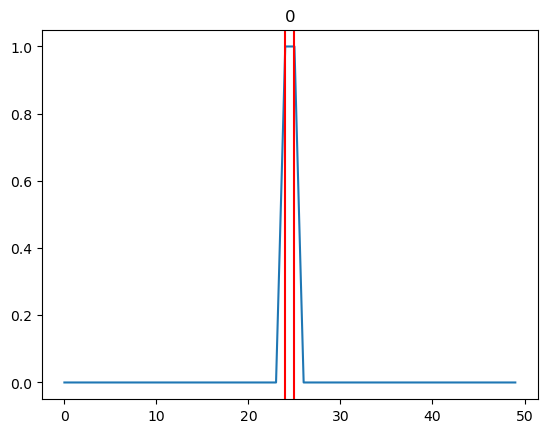

Line segment center: [27.84179639  2.99409503  2.89778565]
Line segment half width: 40.05746382885539
removed 0 points
41804350
[[23, 26]]


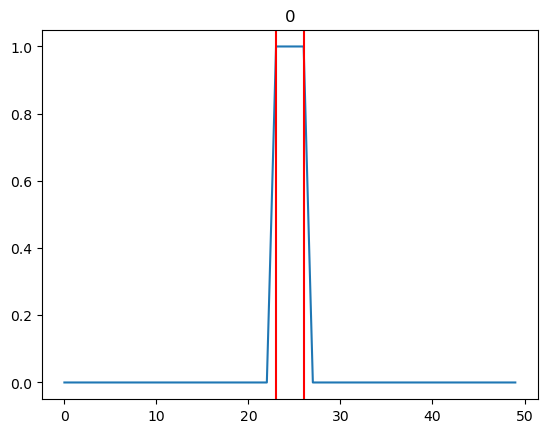

Line segment center: [31.39640002  0.83739037  4.97196969]
Line segment half width: 120.17239148656616
removed 0 points
41805631
[[21, 27]]


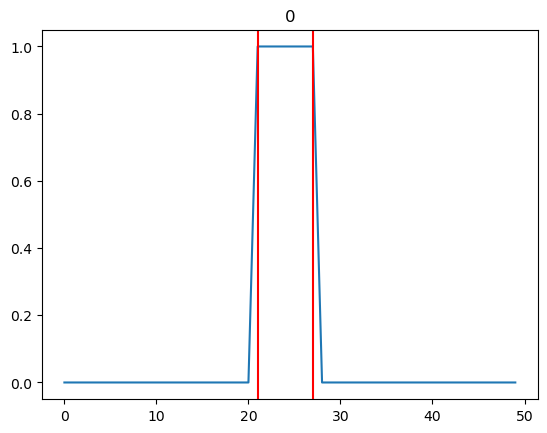

Line segment center: [23.5056258  -0.87326842 22.10868085]
Line segment half width: 240.3447829731323
removed 0 points
42133567
[[24, 29]]


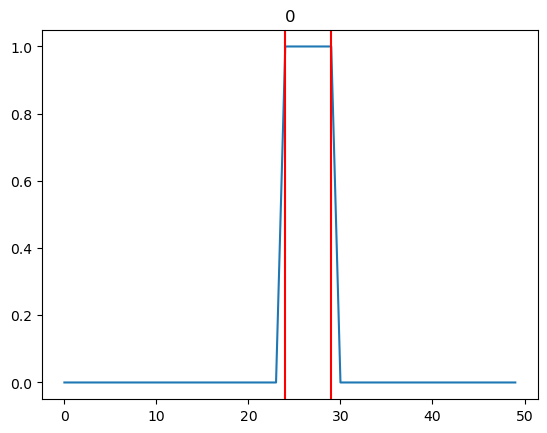

Line segment center: [ 36.69447821   6.12697    -67.8502243 ]
Line segment half width: 200.28731914427695
removed 0 points
42460178
[[22, 24]]


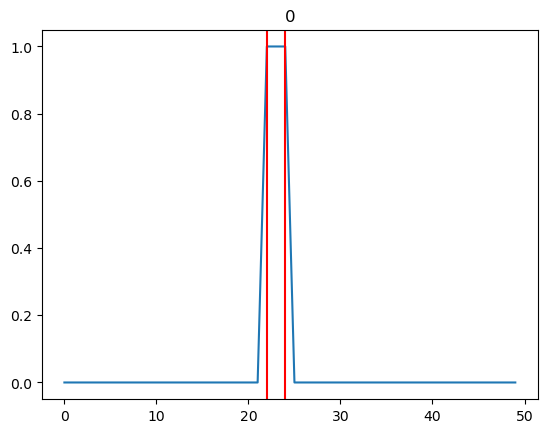

Line segment center: [23.34089857 -2.05819846 58.70164395]
Line segment half width: 80.11492765771078
removed 0 points
42793137
[[20, 21], [26, 27], [36, 37]]


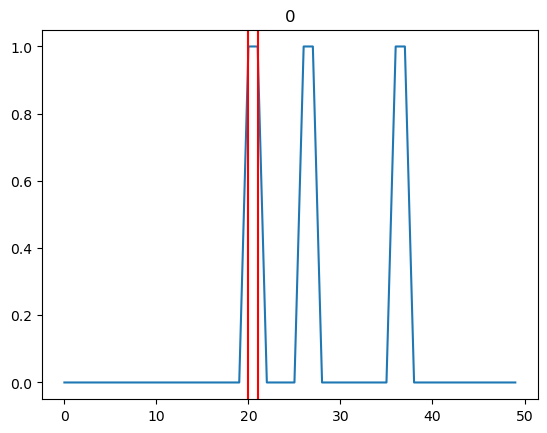

Line segment center: [   4.45246034  -20.1682019  -144.94793588]
Line segment half width: 40.05746382885539
removed 0 points


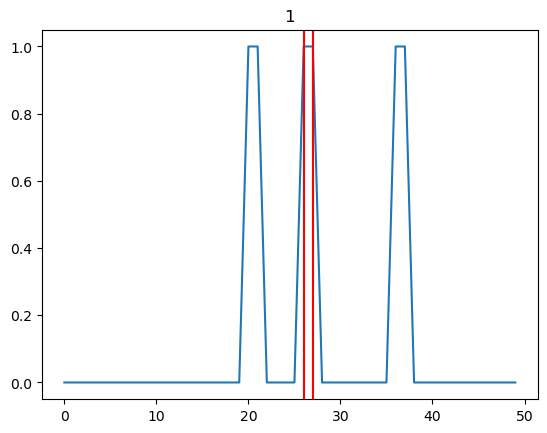

Line segment center: [ 938.68020819  -69.99227666 -889.17210928]
Line segment half width: 40.05746382885539
removed 0 points


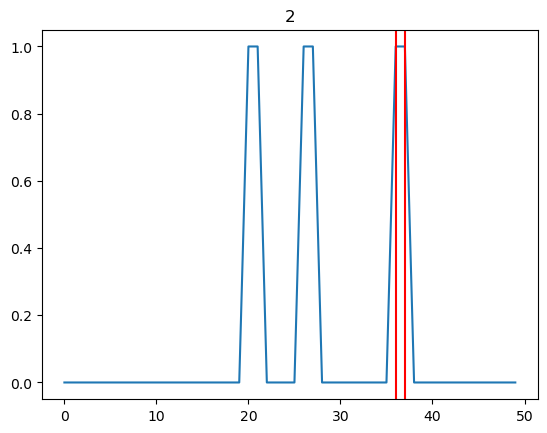

Line segment center: [1302.83897027  -69.99227666 -889.17210928]
Line segment half width: 40.05746382885539
removed 0 points
43116018
[[25, 27]]


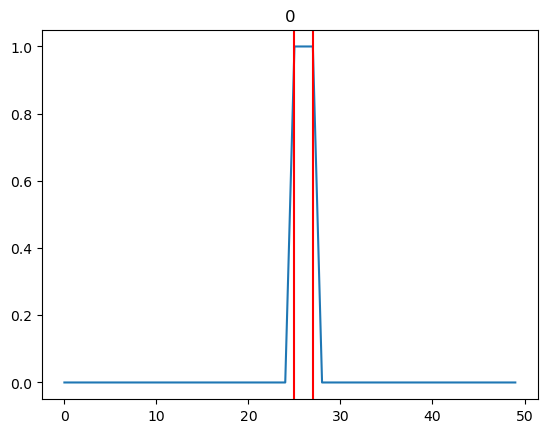

Line segment center: [ 39.44133939   7.07576742 -51.06720316]
Line segment half width: 80.11492765771078
removed 0 points
44104946
[[26, 27]]


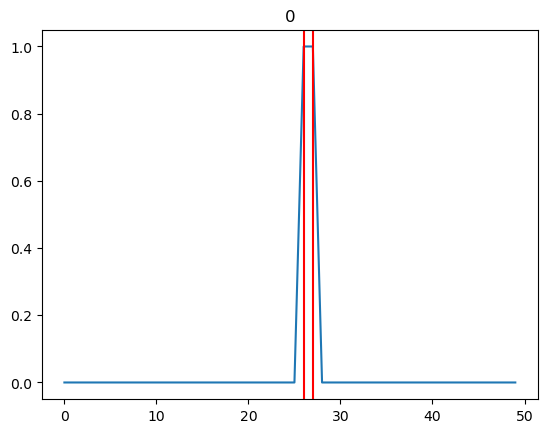

Line segment center: [ 37.75702209  10.36560934 -69.74644663]
Line segment half width: 40.05746382885539
removed 0 points
45092482
[[28, 30]]


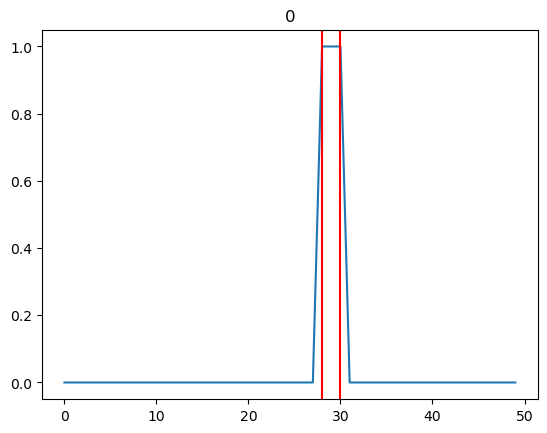

Line segment center: [  47.04902756   16.69981854 -163.10209809]
Line segment half width: 80.11492765771078
removed 0 points
37883207


array([169.60556545,  67.84507581, 712.24468842, 404.16487066,
       232.31055098, 268.30781506])

In [91]:
directionGranularity = 4
directionVectors = genIcosahedron(directionGranularity)

densityField, densityFieldSpacing, densityFieldCorner = courseGrainField(data, defaultLatticeSize=100, returnSpacing=True, returnCorner=True)

print(densityFieldCorner)

lineDirections, lineAnchorPoints, lineLengths = integratedHough3D(data, directionVectors,
                                                                  densityField, densityFieldCorner, densityFieldSpacing,
                                                                  latticeSize=256, neighborDistance=0.01, minPointsPerLine=5)

lineLengths

In [92]:
#lineLength = 100
linePoints = np.array([[lineAnchorPoints[i] - lineDirections[i]*lineLengths[i]/2, lineAnchorPoints[i] + lineDirections[i]*lineLengths[i]/2] for i in range(len(lineDirections))])

linePoints = linePoints.reshape((len(linePoints)*2, 3))

lineSet = o3d.geometry.LineSet()
lineSet.points = o3d.utility.Vector3dVector(linePoints)
lineSet.lines = o3d.utility.Vector2iVector([[i,i+1] for i in range(len(linePoints))[::2]])

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(data)

o3d.visualization.draw_geometries([lineSet, pcd])

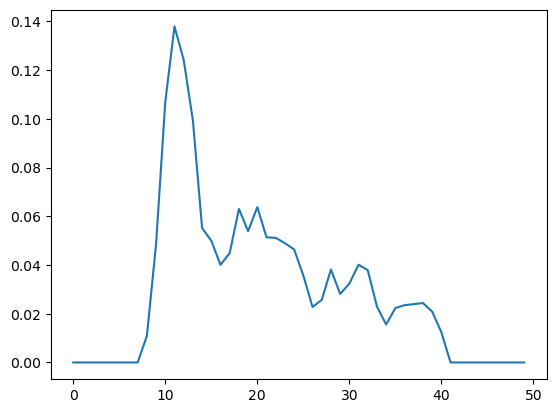

In [9]:
densityField, densityFieldSpacing, densityFieldCorner = courseGrainField(data, returnSpacing=True, returnCorner=True)

densityField = densityField.astype(np.float64)
i = 2

path = np.multiply.outer(np.linspace(-lineLengths[i], lineLengths[i], 50), lineDirections[i]) + lineAnchorPoints[i]
#path = np.multiply.outer(np.linspace(-lineLengths[i], lineLengths[i], 50), np.random.uniform(-1/3, 1/3, size=3)) + lineAnchorPoints[i]

plt.plot(pathIntegralAlongField3D(densityField, path, densityFieldSpacing, densityFieldCorner))
plt.show()